In [1]:
import os
import librosa
import numpy as np
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, GRU, Dense, Embedding, Bidirectional, Layer, TimeDistributed, Attention
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import re

In [2]:
pip install librosa numpy tensorflow scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.


In [46]:
# Adding the name fold to easy access

folder_path = r"/Users/abhignya/Downloads/All Audio WAV"
orth_path = r"/Users/abhignya/Downloads/Flat Ortho Transcript"


In [4]:
def sorted_delta_mean(mfcc):
    delta_width = min(mfcc.shape[1], 9) # 9 is min but can be higher
    delta_mfc = librosa.feature.delta(mfcc, width=delta_width)
    sorted_delta = np.sort(delta_mfc, axis=1)
    delta_mean = np.mean(sorted_delta, axis=1)
    return delta_mean

def normalize_features(feats):
    return (feats - np.min(feats)) / (np.max(feats) - np.min(feats))

def extract_mfcc(audio, sr, n_mfcc=29):
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfccs_mean = np.mean(mfccs, axis=1)

    if mfccs.shape[1] > 1:  # audio longitivity
        sorted_delta = sorted_delta_mean(mfccs)
        mfc_feats = np.concatenate((mfccs_mean, sorted_delta), axis=0)
    else:
        mfc_feats = mfccs_mean

    return mfc_feats

In [5]:
def extract_plp(audio, sr):
    plp_feats = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=27)
    plp_mean = np.mean(plp_feats, axis=1)
    return plp_mean

def visualize_features(mfcc, plp, rmse):
    fig, axs = plt.subplots(3, 1, figsize=(10, 8))
    mfcc = normalize_features(mfcc)
    plp = normalize_features(plp)
    rmse = normalize_features(rmse)

    axs[0].bar(range(len(mfcc)), mfcc)
    axs[0].set_title('Normalized MFCC Features (with Sorted Delta Mean)')
    axs[0].set_xlabel('MFCC Coefficients')
    axs[0].set_ylabel('Normalized Amplitude')

    axs[1].bar(range(len(plp)), plp)
    axs[1].set_title('Normalized PLP Features')
    axs[1].set_xlabel('PLP Coefficients')
    axs[1].set_ylabel('Normalized Amplitude')

    axs[2].bar(range(len(rmse)), rmse)
    axs[2].set_title('Normalized RMSE Features')
    axs[2].set_xlabel('RMSE Coefficients')
    axs[2].set_ylabel('Normalized Amplitude')

    plt.tight_layout()
    plt.show()

In [6]:
def load_audio_file(file_path):
    audio_data, sample_rate = librosa.load(file_path, sr=None)
    return audio_data, sample_rate

def combine_and_normalize_features(mfcc, plp):
    combined_feats = [np.concatenate((m, p), axis=0) for m, p in zip(mfcc, plp)]
    normalized_feats = [normalize_features(feats) for feats in combined_feats]
    return np.array(normalized_feats)

def load_transcription_file(file_path):
    encodings = ['utf-8', 'latin-1', 'windows-1252', 'utf-16']
    text = None

    for encoding in encodings:
      try:
        with open(file_path, 'r', encoding=encoding) as f:
            text = f.read().strip()
            break

      except UnicodeDecodeError:
           continue
      except Exception as e:
          print(f"Error while reading with encoding {encoding}: {e}")
          return None

    if text is None:
        print(f"Could not decode file using any of the provided encodings: {file_path}")
        return ""

    text = re.sub(r'[^\w\s\']', '', text).lower()
    return text


Sample Rate: 44100
Audio Shape: (5053440,)
Max Amplitude: 0.999969482421875
Min Amplitude: -1.0
Mean Amplitude: 4.053019074490294e-05


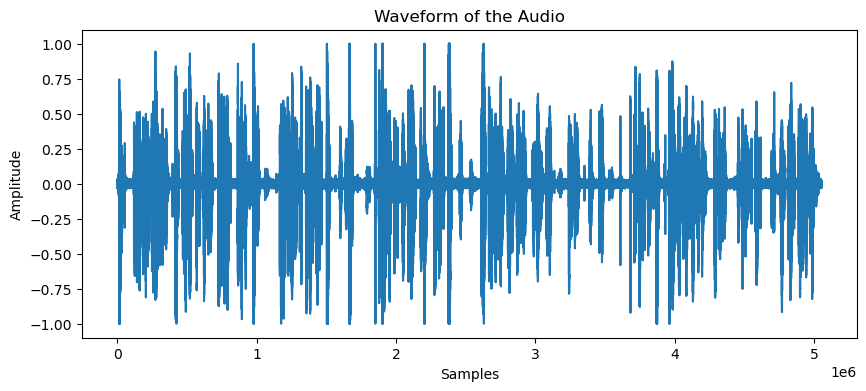

In [7]:
file_path = "/Users/abhignya/Downloads/All Audio WAV/F_0101_15y2m_1.wav"

# Load audio
y, sr = librosa.load(file_path, sr=None)  # `sr=None` keeps original sampling rate

# Print basic info
print(f"Sample Rate: {sr}")
print(f"Audio Shape: {y.shape}")
print(f"Max Amplitude: {np.max(y)}")
print(f"Min Amplitude: {np.min(y)}")
print(f"Mean Amplitude: {np.mean(y)}")

# Plot waveform
plt.figure(figsize=(10, 4))
plt.plot(y)
plt.title("Waveform of the Audio")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()


In [8]:
from keras.saving import register_keras_serializable

In [9]:
def visualize_features(mfcc, plp, rmse):
    fig, axs = plt.subplots(3, 1, figsize=(10, 8))
    mfcc = normalize_features(mfcc)
    plp = normalize_features(plp)
    rmse = normalize_features(rmse)

    axs[0].bar(range(len(mfcc)), mfcc)
    axs[0].set_title('Normalized MFCC Features (with Sorted Delta Mean)')
    axs[0].set_xlabel('MFCC Coefficients')
    axs[0].set_ylabel('Normalized Amplitude')

    axs[1].bar(range(len(plp)), plp)
    axs[1].set_title('Normalized PLP Features')
    axs[1].set_xlabel('PLP Coefficients')
    axs[1].set_ylabel('Normalized Amplitude')

    axs[2].bar(range(len(rmse)), rmse)
    axs[2].set_title('Normalized RMSE Features')
    axs[2].set_xlabel('RMSE Coefficients')
    axs[2].set_ylabel('Normalized Amplitude')

    plt.tight_layout()
    plt.show()

MFCC Shape: (13, 9871)
MFCC Features (first 5 frames):
[[-3.4785391e+02 -3.2016174e+02 -3.1483783e+02 -3.0586859e+02
  -3.0551181e+02]
 [ 8.3741890e+01  8.2578903e+01  7.5587585e+01  7.8790100e+01
   7.7473351e+01]
 [ 1.0877774e+01  7.6732473e+00 -1.4446890e-01 -1.2869320e+00
  -7.1744108e-01]
 [ 2.6715111e+01  3.9239143e+01  4.3650333e+01  4.4018120e+01
   4.6324059e+01]
 [-2.9100761e+00  3.4452236e-01  5.0247068e+00 -8.0717260e-01
  -3.7112408e+00]
 [ 1.1984940e+01  2.1623322e+01  2.7347008e+01  2.2927349e+01
   2.2886549e+01]
 [-1.2532082e+00  3.3222430e+00  5.7846079e+00 -2.0526109e+00
  -4.2211781e+00]
 [ 3.1138904e+00  4.6588473e+00  3.7126551e+00 -3.2909662e-01
  -5.6551492e-01]
 [ 3.8287945e+00  1.6233425e+00 -1.1919324e+00  4.8574519e+00
   7.7437873e+00]
 [-5.7787390e+00  3.5365319e-01 -3.6347699e+00 -2.0086040e+00
  -9.0105209e+00]
 [-6.3286448e+00 -3.6262512e+00 -4.5131907e+00  1.6647990e+00
   1.9751066e+00]
 [-1.7373276e+00 -2.7082002e+00 -5.2499622e-01  4.9146142e+00
   

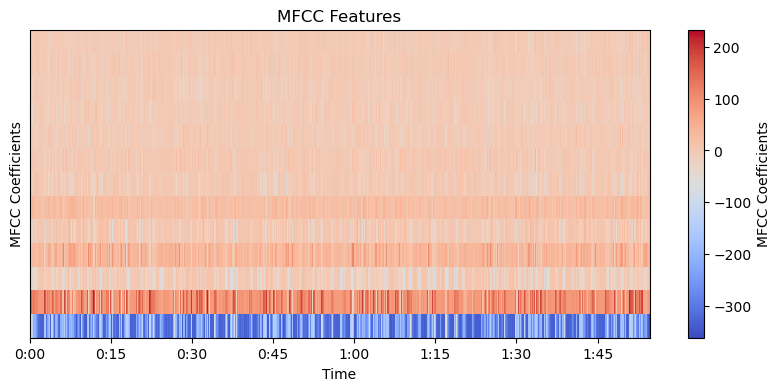

In [10]:
# Load audio
y, sr = librosa.load(file_path, sr=None)

# Extract MFCC
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

print(f"MFCC Shape: {mfcc.shape}")
print(f"MFCC Features (first 5 frames):\n{mfcc[:, :5]}")  # Print first 5 frames for debugging

# Plot MFCC
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, sr=sr, x_axis="time")
plt.colorbar(label="MFCC Coefficients")
plt.title("MFCC Features")
plt.xlabel("Time")
plt.ylabel("MFCC Coefficients")
plt.show()


PLP Shape: (13, 9871)
PLP Features (first 5 frames):
[[6.26586452e-02 1.38429493e-01 9.97360796e-02 1.05752744e-01
  9.45788100e-02]
 [1.61340609e-02 2.07101312e-02 2.03306172e-02 3.28589678e-02
  3.19304168e-02]
 [4.09747800e-03 4.29449650e-03 2.09890306e-03 5.62675670e-03
  5.79690374e-03]
 [2.24922248e-03 3.20305442e-03 2.63030455e-03 2.49426253e-03
  2.68699368e-03]
 [1.67807436e-03 2.63041304e-03 3.68848746e-03 4.85289562e-03
  4.55976371e-03]
 [8.81711894e-04 2.01041787e-03 3.03467573e-03 3.74565669e-03
  3.01522529e-03]
 [1.00606179e-03 1.61906646e-03 2.15601688e-03 2.67735426e-03
  2.71181553e-03]
 [4.82355070e-04 9.44739731e-04 1.48082641e-03 1.75083277e-03
  2.12547998e-03]
 [3.69510642e-04 9.48474626e-04 1.28586264e-03 1.34325412e-03
  1.17481931e-03]
 [4.74385219e-04 1.07412564e-03 1.54701388e-03 2.52154260e-03
  3.03538935e-03]
 [2.89262534e-04 6.11218100e-04 7.89267127e-04 1.39104028e-03
  2.21717218e-03]
 [1.43814454e-04 2.70784018e-04 3.01702239e-04 2.91934208e-04
  2.8

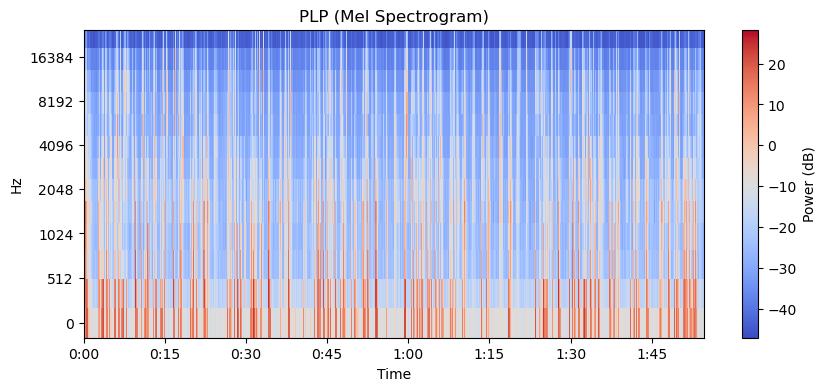

In [11]:
plp = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=13)

print(f"PLP Shape: {plp.shape}")
print(f"PLP Features (first 5 frames):\n{plp[:, :5]}")

# Plot PLP
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(plp), sr=sr, x_axis="time", y_axis="mel")
plt.colorbar(label="Power (dB)")
plt.title("PLP (Mel Spectrogram)")
plt.show()


In [12]:
@register_keras_serializable()
class SGRU(Layer):
    def __init__(self, units, activation='tanh', **kwargs):
        self.units = units
        self.activation = tf.keras.activations.get(activation)
        self.go_backwards = kwargs.pop('go_backwards', False)
        self.return_sequences = kwargs.pop('return_sequences', False)
        self.return_state = kwargs.pop('return_state', False)
        self.stateful = False
        super(SGRU, self).__init__(**kwargs)

    def build(self, input_shape):
        self.Wz = self.add_weight(name='Wz', shape=(input_shape[-1], self.units),
            initializer='glorot_uniform', trainable=True)
        self.Uz = self.add_weight(name='Uz', shape=(self.units, self.units),
            initializer='orthogonal', trainable=True)
        self.Wr = self.add_weight(name='Wr', shape=(input_shape[-1], self.units),
            initializer='glorot_uniform', trainable=True)
        self.Ur = self.add_weight(name='Ur', shape=(self.units, self.units),
            initializer='orthogonal', trainable=True)
        self.Wh = self.add_weight(name='Wh', shape=(input_shape[-1], self.units),
            initializer='glorot_uniform', trainable=True)
        self.Uh = self.add_weight(name='Uh', shape=(self.units, self.units),
            initializer='orthogonal', trainable=True)
        
        self.bz = self.add_weight(name='bz', shape=(self.units,),
            initializer='zeros', trainable=True)
        self.br = self.add_weight(name='br', shape=(self.units,),
            initializer='zeros', trainable=True)
        self.bh = self.add_weight(name='bh', shape=(self.units,),
            initializer='zeros', trainable=True)

        super(SGRU, self).build(input_shape)

    def call(self, inputs, initial_state=None):
        if initial_state is None:
           initial_state = [tf.zeros(shape = (tf.shape(inputs)[0], self.units), dtype = inputs.dtype)]

        h_tm1 = initial_state[0]
        
        time_steps = tf.shape(inputs)[1]
        
        
        def cond(i, h_tm1, outputs):
          return i < time_steps

        def body(i, h_tm1, outputs):
          x_z = K.dot(inputs[:, i, :], self.Wz) + self.bz
          x_r = K.dot(inputs[:, i, :], self.Wr) + self.br
          x_h = K.dot(inputs[:, i, :], self.Wh) + self.bh
            
          z = K.sigmoid(x_z + K.dot(h_tm1, self.Uz))
          r = K.sigmoid(x_r + K.dot(h_tm1, self.Ur))
          h_tilde = self.activation(x_h + K.dot(r*h_tm1, self.Uh))
          h = (1-z)*h_tm1+z*h_tilde

          outputs = outputs.write(i, h)
          return i + 1, h, outputs

        i = tf.constant(0, dtype=tf.int32)
        outputs = tf.TensorArray(dtype=inputs.dtype, size = time_steps)
        _,_,outputs = tf.while_loop(cond, body, loop_vars=[i, h_tm1, outputs])
        outputs = K.permute_dimensions(outputs.stack(), pattern=(1,0,2))
        return outputs

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], self.units)

In [13]:
def build_seq2seq_model_sgru(inp_vocab_size, out_vocab_size, max_len_inp, max_len_out):
    # enc dec attn dec layers
    enc_inp = Input(shape=(max_len_inp,))
    enc_emb = Embedding(inp_vocab_size, 128)(enc_inp)
    enc_gru = Bidirectional(SGRU(128,return_sequences=True))
    enc_out = enc_gru(enc_emb)
    
    enc_gru_2 = Bidirectional(SGRU(64, return_sequences=True))
    enc_out2 = enc_gru_2(enc_out)

    dec_inp = Input(shape=(max_len_out,))
    dec_emb = Embedding(out_vocab_size, 128)(dec_inp)
    dec_gru = SGRU(128, return_sequences=True)
    dec_out = dec_gru(dec_emb, initial_state = None)
    
    dec_gru_2 = SGRU(128, return_sequences=True)
    dec_out2 = dec_gru_2(dec_out, initial_state = None)
   
    attn_layer = tf.keras.layers.Attention()
    attn_out = attn_layer([dec_out2, enc_out2])

    dec_cat_inp = tf.keras.layers.concatenate([dec_out2, attn_out])
    dec_time_dist = TimeDistributed(Dense(out_vocab_size, activation='softmax'))
    dec_outputs = dec_time_dist(dec_cat_inp)

    model = Model([enc_inp, dec_inp], dec_outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [14]:

# Define the directory path where the audio files are stored
directory_path = "/Users/abhignya/Downloads/All Audio WAV"

# Get a list of all files in the directory
all_files = os.listdir(directory_path)

# Filter out only the audio files (.mp3 and .wav)
audio_files = [file for file in all_files if file.endswith('.mp3') or file.endswith('.wav')]

# Store the selected audio files
selected_files = audio_files

# Print the selected files
print("Audio Files:", selected_files)


Audio Files: ['F_0101_15y2m_1.wav', 'M_1017_12y5m_1.wav', 'M_0556_08y0m_1.wav', 'M_0212_11y1m_1.wav', 'M_0061_14y9m_1.wav', 'M_0880_14y6m_1.wav', 'F_0988_12y8m_1.wav', 'F_0558_10y0m_1.wav', 'M_0030_12y7m_1.wav', 'M_1100_28y0m_1.wav', 'M_1104_40y0m_1.wav', 'F_1039_09y3m_1.wav', 'M_0104_12y8m_1.wav', 'M_1099_25y0m_1.wav', 'M_1106_25y0m_1.wav', 'M_0061_14y7m_1.wav', 'F_0988_13y6m_1.wav', 'M_1112_09y9m.1.wav', 'M_0028_15y11m_1.wav', 'M_0030_12y9m_1.wav', 'M_0234_09y9m_1.wav', 'M_1017_11y8m_1.wav', 'M_0138_13y3m_1.wav', 'M_0098_09y8m_1.wav', 'M_0216_12y1m_1.wav', 'M_0102_09y6m_1.wav', 'M_0030_19y5m_1.wav', 'M_0092_09y11m_1.wav', 'M_0052_14y4m_1.wav', 'M_0100_13y7m_1.wav', 'M_0219_14y3m_1.wav', 'F_0879_12y5m_1.wav', 'M_0030_13y1m_1.wav', 'M_0880_13y4m_1.wav', 'M_0030_12y1m_1.wav', 'M_0216_11y6m_1.wav', 'M_0087_08y4m_1.wav', 'M_0061_14y3m_1.wav', 'F_0818_12y4m_1.wav', 'M_0078_17y11m_1.wav', 'M_0213_10y10m_1.wav', 'F_0987_12y8m_1.wav', 'M_0214_09y4m_1.wav', 'M_0030_12y1m_2.wav', 'M_0100_12y3m_

In [15]:
# Initialize lists
file_paths = []
mfcc_feats = []
plp_feats = []
rmse_feats = []
target_seqs = []


In [16]:
# Extract features from audio files
for file_name in selected_files:
    file_path = os.path.join(folder_path, file_name)
    file_paths.append(file_path)
    
    if file_name.endswith('.mp3') or file_name.endswith('.WAV'):
        
        audio, sr = librosa.load(file_path, sr=None)

        if len(audio) == 0:
            print(f"Skipping empty audio file: {file_path}")
            if file_path in file_paths:
              file_paths.remove(file_path)
            continue

        # Extract features
        mfcc = extract_mfcc(audio, sr)
        plp = extract_plp(audio, sr)
        rmse_feature = librosa.feature.rms(y=audio)
        rmse_mean = np.mean(rmse_feature)
        rmse_peak = np.max(rmse_feature)
        print(rmse_feats)
        print(rmse_mean)

        mfcc_feats.append(mfcc)
        plp_feats.append(plp)
        rmse_feats.append([rmse_mean, rmse_peak])

        # Load transcriptions
        base_name = os.path.splitext(file_name)[0]
        orth_file_path = os.path.join(orth_path, base_name + '.orth')
        if os.path.exists(orth_file_path):
            transcription = load_transcription_file(orth_file_path)
            target_seqs.append(transcription)
        else:
            print(f"Transcription file not found: {orth_file_path}")
            if file_path in file_paths:
                file_paths.remove(file_path)
            mfcc_feats.pop()
            plp_feats.pop()
            rmse_feats.pop()
            

In [17]:
import jiwer
def calculate_wer(target, prediction):
    transformation = jiwer.Compose([jiwer.ToLowerCase(), jiwer.RemoveMultipleSpaces(), jiwer.Strip()])
    return jiwer.wer(transformation(target), transformation(prediction))
    
def calculate_cer(target, prediction):
    transformation = jiwer.Compose([jiwer.ToLowerCase(), jiwer.RemoveMultipleSpaces(), jiwer.Strip()])
    return jiwer.cer(transformation(target), transformation(prediction))

In [18]:
from tensorflow.keras.utils import register_keras_serializable
import tensorflow as tf

@register_keras_serializable()
def build_seq2seq_model_sgru(inp_vocab_size, out_vocab_size, max_len_inp, max_len_out):
    inputs = tf.keras.layers.Input(shape=(max_len_inp, inp_vocab_size))
    
    # Encoder
    x = tf.keras.layers.GRU(256, return_sequences=True)(inputs)
    x = tf.keras.layers.GRU(256, return_sequences=True)(x)

    # Decoder
    outputs = tf.keras.layers.Dense(out_vocab_size, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return model  


In [19]:

mfcc_feats = [m.reshape(m.shape[0], -1) if len(m.shape) == 1 else m for m in mfcc_feats]
plp_feats = [p.reshape(p.shape[0], -1) if len(p.shape) == 1 else p for p in plp_feats]
def pad_features(features, max_len):
    padded = []
    for f in features:
        if f.shape[0] < max_len:
            pad_width = ((0, max_len - f.shape[0]), (0, 0))  # Ensure correct padding shape
            padded.append(np.pad(f, pad_width, mode='constant'))
        else:
            padded.append(f[:max_len])  # Truncate if too long
    return padded


In [20]:
import os
import librosa
import numpy as np

# Initialize feature lists
mfcc_feats = []
plp_feats = []
rmse_feats = []

# Define your folder and file list
folder_path = "/Users/abhignya/Downloads/All Audio WAV"
selected_files = os.listdir(folder_path)

def extract_mfcc(audio, sr):
    return librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13).flatten()  # Example MFCC extraction

def extract_plp(audio, sr):
    return librosa.feature.melspectrogram(y=audio, sr=sr).flatten()  # Example PLP extraction

for file_name in selected_files:
    file_path = os.path.join(folder_path, file_name)
    
    try:
        # Load audio
        audio, sr = librosa.load(file_path, sr=None)

        if len(audio) == 0:
            print(f"Skipping empty audio file: {file_path}")
            continue  # Skip empty files

        # Extract features
        mfcc = extract_mfcc(audio, sr)
        plp = extract_plp(audio, sr)

        # RMSE Feature Extraction
        rmse_feature = librosa.feature.rms(y=audio).squeeze()

        if rmse_feature.size == 0:
            print(f"Warning: RMSE feature is empty for {file_name}")
            rmse_mean, rmse_peak = 0.0, 0.0  # Assign default values
        else:
            rmse_mean = np.mean(rmse_feature)
            rmse_peak = np.max(rmse_feature)

        # Append Features
        mfcc_feats.append(mfcc)
        plp_feats.append(plp)
        rmse_feats.append([rmse_mean, rmse_peak])

    except Exception as e:
        print(f"Error processing {file_name}: {e}")

# Convert lists to numpy arrays for easier handling in ML models
mfcc_feats = np.array(mfcc_feats, dtype=object)
plp_feats = np.array(plp_feats, dtype=object)
rmse_feats = np.array(rmse_feats)

print("Feature extraction complete.")
print(f"MFCC Shape: {mfcc_feats.shape}")
print(f"PLP Shape: {plp_feats.shape}")
print(f"RMSE Shape: {rmse_feats.shape}")


Feature extraction complete.
MFCC Shape: (138,)
PLP Shape: (138,)
RMSE Shape: (138, 2)


In [21]:
def combine_and_normalize_features(mfcc, plp):
    # Ensure all features are at least 2D
    mfcc = [m.reshape(m.shape[0], -1) if len(m.shape) == 1 else m for m in mfcc]
    plp = [p.reshape(p.shape[0], -1) if len(p.shape) == 1 else p for p in plp]

    # Ensure all features have the same number of time steps
    max_len = max(max(f.shape[0] for f in mfcc), max(f.shape[0] for f in plp))

    mfcc_padded = pad_features(mfcc, max_len)
    plp_padded = pad_features(plp, max_len)

    # Make sure both features have the same number of columns
    feature_dim = max(mfcc_padded[0].shape[1], plp_padded[0].shape[1])

    mfcc_padded = [np.pad(m, ((0, 0), (0, feature_dim - m.shape[1])), mode='constant') for m in mfcc_padded]
    plp_padded = [np.pad(p, ((0, 0), (0, feature_dim - p.shape[1])), mode='constant') for p in plp_padded]

    # Concatenate features
    combined_feats = [np.concatenate((m, p), axis=1) for m, p in zip(mfcc_padded, plp_padded)]
    
    # Normalize
    normalized_feats = [normalize_features(feats) for feats in combined_feats]

    return np.stack(normalized_feats, axis=0)  # Use `np.stack()` instead of `np.array()`

X = combine_and_normalize_features(mfcc_feats, plp_feats)


In [3]:
import librosa
import librosa.display
import numpy as np
import torchaudio
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import torch

# Load model and processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")

# Load audio file
audio_path = "/Users/abhignya/Downloads/All Audio WAV/F_0558_10y0m_1.wav"
audio, sr = librosa.load(audio_path, sr=16000)

# Convert to tensor
input_values = processor(audio, sampling_rate=sr, return_tensors="pt").input_values

# Predict phonemes
with torch.no_grad():
    logits = model(input_values).logits

predicted_ids = torch.argmax(logits, dim=-1)

# Decode to phonemes
transcription = processor.batch_decode(predicted_ids)[0]
print("Phoneme Mapping:", transcription)


Some weights of the model checkpoint at facebook/wav2vec2-large-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.masked_spec_embed', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You s

Phoneme Mapping: AM I LAVE WHAT SHE NEIGHBOURS I STAND E DOORS ON CRECK CHARBED WHICHE'S ABOUT THREE WITCHES I LAVE PLAYIN ARANDERS AND TERNIS AN A CRICKET SOMETIMES AT SCHOOL AM AT PRAMPS GOT A I PE RANDERS EVERY SINGLE DAY BUT A DEM DE YE SEVEN CAN'T PLAY THAT GAMES BECAUSE  GO I GOT AM DIFFERENT FRIENDS THE BOOK THAT I LIKE A THE AUTHORS HA LIKE A POOR GENNINGS AM TWO BLUO ROLDAR AND GOT THE GOD NAME AM I DOT LIKE A'M PORTUNE FOOTBOARD THAT MUCH O ROGBY M I THINK A'M AM PRETTY GOOD AT ART METS AN SIENCE MA HER LIKE BEEN GORLY BECAUSE TO BIT HARD FOR ME EVEN THOUG AM ACAS ASPIK BEEN GOLY AN SCOLL IS OCAY FOM ME A FANDYY E SEE SOT THAT HARD FOR ME AM I' GOT A MUC TUOTER HADE HAD A BABY SO I GOT A SUPPLY TEACHER BUT NASH AM SHE LEFT AS SO WE GOT O AM O FOME TO CER BACK AN SH GOT TOBABY SONS AM I ALSO LIKE WICIN FRIENS AM THAN OR FOUR AM I'VE GOT TWO BROTHERS AN FOS THREE SISTERS I GOT AM MY BROTHER MASTER ATON ME I GOT TWO SISTERS O ONE BROTHER WHO A YOUNGER THAN ME MY BROTHER IS SEVEN

In [23]:
# Create character-to-index mapping
char_map = {char: idx for idx, char in enumerate("abcdefghijklmnopqrstuvwxyz' ", start=1)}
char_map["<pad>"] = 0  # Padding token
char_map["<unk>"] = len(char_map)  # Unknown token

# Convert transcription to indices
def text_to_indices(text, char_map):
    return [char_map.get(char, char_map["<unk>"]) for char in text.lower()]

transcription_indices = text_to_indices(transcription, char_map)
print("Transcription Indices:", transcription_indices)

Transcription Indices: [5, 13, 28, 9, 28, 7, 1, 28, 9, 27, 13, 28, 9, 14, 12, 25, 28, 1, 28, 20, 5, 14, 28, 1, 14, 9, 19, 8, 5, 18, 28, 9, 27, 13, 28, 4, 15, 9, 14, 7, 28, 13, 25, 28, 6, 9, 18, 19, 20, 28, 25, 5, 1, 18, 28, 15, 6, 28, 5, 13, 28, 7, 19, 5, 3, 5, 19, 28, 5, 13, 28, 9, 27, 13, 28, 19, 20, 21, 4, 25, 9, 14, 7, 28, 1, 18, 20, 28, 8, 9, 19, 20, 15, 18, 25, 28, 5, 13, 28, 20, 18, 9, 16, 12, 5, 28, 19, 9, 5, 14, 20, 19, 28, 5, 13, 28, 5, 13, 28, 19, 16, 1, 14, 9, 19, 8, 28, 1, 14, 7, 28, 4, 5, 13, 15, 7, 18, 1, 16, 8, 9, 3, 1, 12, 28, 4, 5, 19, 9, 14, 5, 28, 5, 13, 28, 13, 28, 13, 25, 28, 6, 1, 22, 15, 18, 9, 20, 5, 28, 19, 21, 2, 10, 5, 3, 20, 28, 15, 21, 20, 28, 15, 6, 28, 1, 12, 12, 28, 1, 12, 12, 28, 1, 13, 28, 15, 21, 20, 28, 15, 6, 28, 1, 12, 12, 28, 15, 6, 28, 20, 5, 13, 28, 9, 19, 28, 13, 28, 1, 18, 20, 28, 5, 13, 28, 1, 13, 4, 28, 28, 7, 5, 28, 1, 14, 28, 13, 25, 28, 6, 18, 9, 5, 14, 4, 19, 28, 1, 18, 5, 28, 13, 1, 13, 28, 12, 21, 3, 25, 28, 5, 13, 28, 12, 9, 19, 5, 1

In [ ]:
class DNNModel(nn.Module):
    def __init__(self, input_dim=13, hidden_dim=128, num_layers=1):
        super(DNNModel, self).__init__()
        self.feature_proj = nn.Linear(input_dim, 40)  # Adjusts input features
        self.gru = nn.GRU(40, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)  # Binary classification output
    
    def forward(self, x):
        x = self.feature_proj(x)  # Fix shape issue
        x, _ = self.gru(x)
        x = self.fc(x[:, -1, :])  # Take last time step output
        return torch.sigmoid(x)  # Apply activation


In [24]:
import os
import librosa
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC

# Load Wav2Vec2 processor & model
processor = Wav2Vec2Processor.from_pretrained("jonatasgrosman/wav2vec2-large-xlsr-53-english")
model = Wav2Vec2ForCTC.from_pretrained("jonatasgrosman/wav2vec2-large-xlsr-53-english")

# Path to audio files
audio_folder = "/Users/abhignya/Downloads/All Audio WAV"

# Character-to-index mapping
char_map = {char: idx for idx, char in enumerate("abcdefghijklmnopqrstuvwxyz' ", start=1)}
char_map["<pad>"] = 0  # Padding token
char_map["<unk>"] = len(char_map)  # Unknown token
PAD_INDEX = char_map["<pad>"]

# Function to convert text to indices
def text_to_indices(text, char_map):
    return [char_map.get(char, char_map["<unk>"]) for char in text.lower()]

# Initialize max length and processed data storage
max_length = 0
processed_data = []

# Process files efficiently
for filename in os.listdir(audio_folder):
    if filename.endswith(".wav"):
        audio_path = os.path.join(audio_folder, filename)

        # Load a short snippet if file is too long (adjust duration as needed)
        audio, sr = librosa.load(audio_path, sr=16000, duration=30)

        # Convert to tensor
        input_values = processor(audio, sampling_rate=sr, return_tensors="pt").input_values

        # Predict transcription
        with torch.no_grad():
            logits = model(input_values).logits
        predicted_ids = torch.argmax(logits, dim=-1)
        transcription = processor.batch_decode(predicted_ids)[0]

        # Convert transcription to indices
        indices = text_to_indices(transcription, char_map)
        processed_data.append(indices)

        # Update max length
        max_length = max(max_length, len(indices))

print(f"Maximum Sequence Length: {max_length}")

# Pad all sequences to max_length
padded_sequences = [seq + [PAD_INDEX] * (max_length - len(seq)) for seq in processed_data]

# Convert to tensor
padded_sequences_tensor = torch.tensor(padded_sequences)

print(f" Padded Sequences Shape: {padded_sequences_tensor.shape}")  # (num_samples, max_length)


Some weights of the model checkpoint at jonatasgrosman/wav2vec2-large-xlsr-53-english were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_v', 'wav2vec2.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at jonatasgrosman/wav2vec2-large-xlsr-53-english and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
Y

Maximum Sequence Length: 348
 Padded Sequences Shape: torch.Size([138, 348])


In [25]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, GRU, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# Define the S-GRU Seq2Seq model
def build_seq2seq_model_sgru(inp_vocab_size, out_vocab_size, max_len_inp, max_len_out, embedding_dim=256, units=512):
    """
    Builds a sequence-to-sequence (Seq2Seq) model using Stacked Gated Recurrent Units (S-GRU)
    for stuttering speech recognition.
    
    Args:
        inp_vocab_size: Size of input vocabulary
        out_vocab_size: Size of output vocabulary
        max_len_inp: Maximum length of input sequence
        max_len_out: Maximum length of output sequence
        embedding_dim: Dimension of embedding layer (default=256)
        units: Number of GRU units per layer (default=512)
    
    Returns:
        Model: Compiled Seq2Seq model
    """
    # Encoder
    encoder_inputs = Input(shape=(max_len_inp,))
    enc_emb = Embedding(input_dim=inp_vocab_size, output_dim=embedding_dim, mask_zero=True)(encoder_inputs)
    encoder_gru1 = GRU(units, return_sequences=True, return_state=True)
    encoder_gru2 = GRU(units, return_state=True)  # Stacked GRU
    enc_out, enc_state1 = encoder_gru1(enc_emb)
    _, enc_state2 = encoder_gru2(enc_out)

    # Decoder
    decoder_inputs = Input(shape=(max_len_out,))
    dec_emb = Embedding(input_dim=out_vocab_size, output_dim=embedding_dim, mask_zero=True)(decoder_inputs)
    decoder_gru = GRU(units, return_sequences=True, return_state=True)
    dec_out, _ = decoder_gru(dec_emb, initial_state=enc_state2)
    decoder_dense = Dense(out_vocab_size, activation='softmax')
    outputs = decoder_dense(dec_out)

    # Define and compile model
    model = Model([encoder_inputs, decoder_inputs], outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Define model parameters
inp_vocab_size = 1000  # Adjust based on dataset
out_vocab_size = 1000  # Adjust based on dataset
max_len_inp = 348  # Maximum input sequence length (Based on your dataset)
max_len_out = 348  # Maximum output sequence length

# Build the model
dnn_model = build_seq2seq_model_sgru(inp_vocab_size, out_vocab_size, max_len_inp, max_len_out)

# Early Stopping Callback
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Summary of the model
dnn_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 348)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 348, 256)  │    256,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 348)       │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 348)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ [(None, 348,      │  1,182,720 │ embedding[0][0],  │
│                     │ 512), (None,      │            │ not_equal[0][0]   │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 348, 256)  │    256,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ [(None, 512),     │  1,575,936 │ gru[0][0],        │
│                     │ (None, 512)]      │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_2 (GRU)         │ [(None, 348,      │  1,182,720 │ embedding_1[0][0… │
│                     │ 512), (None,      │            │ gru_1[0][1]       │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 348, 1000) │    513,000 │ gru_2[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,966,376 (18.95 MB)

 Trainable params: 4,966,376 (18.95 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
# Example: Tokenizing and converting to indices
target_tokenizer = Tokenizer()  # Ensure you have a tokenizer
target_tokenizer.fit_on_texts(target_seqs)
target_indicies = target_tokenizer.texts_to_sequences(target_seqs)  # Convert text to integer sequences


In [57]:
import os
import torch
import torchaudio
import librosa
import numpy as np
from torch.utils.data import Dataset, DataLoader

class AudioDataset(Dataset):
    def __init__(self, data_dir, label_file):
        """
        Args:
            data_dir (str): Path to directory containing audio files.
            label_file (str): Path to CSV file with labels.
        """
        self.data_dir = data_dir
        self.labels = self.load_labels(label_file)

    def load_labels(self, label_file):
        """Load labels from a CSV file."""
        import pandas as pd
        df = pd.read_csv(label_file)  # Ensure CSV has 'filename' and 'label' columns
        return {row["filename"]: row["label"] for _, row in df.iterrows()}

    def extract_features(self, file_path):
        """Extract MFCC features from an audio file."""
        waveform, sr = librosa.load(file_path, sr=16000)
        mfcc = librosa.feature.mfcc(y=waveform, sr=sr, n_mfcc=40)
        return torch.tensor(mfcc.T, dtype=torch.float32)  # Shape: (time_steps, features)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        file_name = list(self.labels.keys())[idx]
        file_path = os.path.join(self.data_dir, file_name)
        
        features = self.extract_features(file_path)
        label = torch.tensor(self.labels[file_name], dtype=torch.float32)

        return features, label


In [47]:
# Pad target sequences
X_enc = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=max_len_inp, padding='post', dtype='float32')
X_dec = tf.keras.preprocessing.sequence.pad_sequences(target_indicies, maxlen=max_len_out, padding='post', dtype='int32')
y_dec = tf.keras.preprocessing.sequence.pad_sequences(target_indicies, maxlen=max_len_out, padding='post', dtype='int32')

print("file_paths:", file_paths)
print("target_seqs:", target_seqs)

print("Shape of X:", X.shape)
print("Shape of X_enc:", X_enc.shape)
print("Shape of X_dec:", X_dec.shape)
print("Shape of y_dec:", y_dec.shape)
print("Max len input:", max_len_inp)
print("Max len target:", max_len_out)
print("Input Vocab Size:", inp_vocab_size)
print("Output Vocab Size:", out_vocab_size)

# checking the sgru with ... the se1seq
dnn_model = build_seq2seq_model_sgru(inp_vocab_size, out_vocab_size, max_len_inp, max_len_out)
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

file_paths: ["'/Users/abhignya/Downloads/All Audio WAV'/F_0101_15y2m_1.wav", "'/Users/abhignya/Downloads/All Audio WAV'/M_1017_12y5m_1.wav", "'/Users/abhignya/Downloads/All Audio WAV'/M_0556_08y0m_1.wav", "'/Users/abhignya/Downloads/All Audio WAV'/M_0212_11y1m_1.wav", "'/Users/abhignya/Downloads/All Audio WAV'/M_0061_14y9m_1.wav", "'/Users/abhignya/Downloads/All Audio WAV'/M_0880_14y6m_1.wav", "'/Users/abhignya/Downloads/All Audio WAV'/F_0988_12y8m_1.wav", "'/Users/abhignya/Downloads/All Audio WAV'/F_0558_10y0m_1.wav", "'/Users/abhignya/Downloads/All Audio WAV'/M_0030_12y7m_1.wav", "'/Users/abhignya/Downloads/All Audio WAV'/M_1100_28y0m_1.wav", "'/Users/abhignya/Downloads/All Audio WAV'/M_1104_40y0m_1.wav", "'/Users/abhignya/Downloads/All Audio WAV'/F_1039_09y3m_1.wav", "'/Users/abhignya/Downloads/All Audio WAV'/M_0104_12y8m_1.wav", "'/Users/abhignya/Downloads/All Audio WAV'/M_1099_25y0m_1.wav", "'/Users/abhignya/Downloads/All Audio WAV'/M_1106_25y0m_1.wav", "'/Users/abhignya/Downloads

In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Hyperparameters
input_dim = 40  # Feature size (e.g., MFCC/WMFCC features)
hidden_dim = 128
num_layers = 2
dropout = 0.2
learning_rate = 1e-3
batch_size = 32
num_epochs = 50
patience = 5

# Define a simple Deep Neural Network (DNN)
class DNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return self.sigmoid(x)

# Initialize the model
model = DNN(input_dim, hidden_dim)

# Loss Function, Optimizer, and Scheduler
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

def train_model(train_loader, val_loader):
    """Train the model with early stopping and learning rate scheduling."""
    best_val_loss = float('inf')
    early_stop_counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.float(), targets.float()  # Ensure correct dtype
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        val_loss, val_acc = evaluate_model(val_loader)
        scheduler.step(val_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered!")
                break
    
    print("Training complete.")

def evaluate_model(loader):
    """Evaluate the model on validation or test data."""
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
    
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.float(), targets.float()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
   


In [67]:
from torch.utils.data import DataLoader, random_split

# Assume train_dataset is already created
train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size  # 20% for validation

train_data, val_data = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)


In [71]:
input_dim = 13  # Match dataset feature size
inputs = inputs.view(inputs.size(0), -1)  # Converts [batch_size, seq_len, feature_dim] → [batch_size, seq_len * feature_dim]


In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Device Configuration (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loss Function & Optimizer
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

def train_model(model, train_loader, val_loader, num_epochs=50, patience=5):
    """Train the model with early stopping & learning rate scheduling."""
    model.to(device)  # Move model to GPU if available
    best_val_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device).float(), targets.to(device).float()
            
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()  # Ensure correct output shape
            
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        val_loss, val_acc = evaluate_model(model, val_loader)

        scheduler.step(val_loss)  # Reduce LR if validation loss plateaus

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Early Stopping Check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered!")
                break

    print("Training complete.")

def evaluate_model(model, loader):
    """Evaluate the model on validation/test data."""
    model.eval()
    correct, total, total_loss = 0, 0, 0

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device).float(), targets.to(device).float()
            outputs = model(inputs).squeeze()
            
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            
            predicted = (outputs > 0.5).float()
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

    avg_loss = total_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy


In [76]:
input_dim = 13  # Instead of 40


In [78]:
class DNNModel(nn.Module):
    def __init__(self, input_dim=13, hidden_dim=128, num_layers=1):
        super(DNNModel, self).__init__()
        self.feature_proj = nn.Linear(input_dim, 40)  # Adjusts input features
        self.gru = nn.GRU(40, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)  # Binary classification output
    
    def forward(self, x):
        x = self.feature_proj(x)  # Fix shape issue
        x, _ = self.gru(x)
        x = self.fc(x[:, -1, :])  # Take last time step output
        return torch.sigmoid(x)  # Apply activation


In [80]:
for inputs, targets in train_loader:
    print(inputs.shape)  # Check shape before passing to model


torch.Size([32, 50, 13])
torch.Size([32, 50, 13])
torch.Size([16, 50, 13])


In [81]:
import torch
import torch.nn as nn

class DNNModel(nn.Module):
    def __init__(self, input_dim=13, hidden_dim=128, num_layers=1):
        super(DNNModel, self).__init__()
        self.feature_proj = nn.Linear(input_dim, 40)  # Project 13 → 40
        self.gru = nn.GRU(40, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)  # Binary classification

    def forward(self, x):
        x = self.feature_proj(x)  # Apply projection
        x, _ = self.gru(x)
        x = self.fc(x[:, -1, :])  # Take last timestep
        return torch.sigmoid(x)  # Apply activation


In [82]:
model = DNNModel().to(device)
train_model(model, train_loader, val_loader, num_epochs=50)


Epoch 1/50, Train Loss: 0.6939, Val Loss: 0.6940, Val Acc: 0.5000
Epoch 2/50, Train Loss: 0.6938, Val Loss: 0.6940, Val Acc: 0.5000
Epoch 3/50, Train Loss: 0.6942, Val Loss: 0.6940, Val Acc: 0.5000
Epoch 4/50, Train Loss: 0.6977, Val Loss: 0.6940, Val Acc: 0.5000
Epoch 5/50, Train Loss: 0.6936, Val Loss: 0.6940, Val Acc: 0.5000
Epoch 6/50, Train Loss: 0.6925, Val Loss: 0.6940, Val Acc: 0.5000
Early stopping triggered!
Training complete.


In [97]:
import re
import speech_recognition as sr

# Define common interjections (can be expanded)
INTERJECTIONS = {"um", "uh", "er", "ah", "hmm", "like", "you know", "so", "well"}

def remove_repetitions(text):
    """Removes word repetitions (e.g., 'I I want' -> 'I want')."""
    return re.sub(r'\b(\w+)( \1\b)+', r'\1', text)

def remove_prolongations(text):
    """Removes prolongations (e.g., 's-s-sorry' -> 'sorry')."""
    return re.sub(r'\b(\w)-+\1+\b', r'\1', text)

def remove_interjections(text):
    """Removes filler words (e.g., 'um', 'uh', 'hmm')."""
    words = text.split()
    return ' '.join([word for word in words if word.lower() not in INTERJECTIONS])

def clean_transcription(transcription):
    """Applies all cleaning functions to process text."""
    transcription = remove_repetitions(transcription)
    transcription = remove_prolongations(transcription)
    transcription = remove_interjections(transcription)
    return transcription

def transcribe_audio(file_path):
    """Transcribes speech from an audio file."""
    recognizer = sr.Recognizer()
    with sr.AudioFile(file_path) as source:
        audio = recognizer.record(source)
    try:
        transcription = recognizer.recognize_google(audio)
        cleaned_text = clean_transcription(transcription)
        return cleaned_text
    except sr.UnknownValueError:
        return "Speech Recognition could not understand the audio."
    except sr.RequestError:
        return "Could not request results, please check your internet connection."

# Example usage
audio_file = "/Users/abhignya/Downloads/All Audio WAV/F_0101_15y2m_1.wav"  # Replace with actual file path
cleaned_transcription = transcribe_audio(audio_file)
print("Cleaned Transcription:", cleaned_transcription)

Cleaned Transcription: ok I mean you can understand I am studying out history and 7 science and Spanish and the Cockroaches Friday Australia
